In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta
import cftime

In [2]:
case = "MESOCOM"
path = "/glade/scratch/jinmuluo/archive/MESOCOM/lnd/hist/" 
start_date = date(2022, 1, 1)
end_date = date(2023, 1, 1)
NO_LEAP = True

# Because out model simulation results are in daily average
# delta_months = (end_date.year - start_date.year)*12 + end_date.month - start_date.month + 1
delta_days = (end_date - start_date).days

In [3]:
NInput = ['MANURE_N_GRZ', 'MANURE_N_BARNS', 'FERT_N_APP', 'NDEP_TO_SMINN', 'NFIX', 'FERT_TO_SMINN', 'NITRATE_N_TO_SMINN', 'F_CANOPY_TO_SOIL']
MID_TERM_FAN = ["FERT_NO3_TO_SOIL", "MANURE_NO3_TO_SOIL"]
RUNOFF = ["MANURE_NITRATE_RUNOFF", 'FERT_NITRATE_RUNOFF', "CANOPY_TO_SOIL","FERT_NITRATE_TO_SOIL", "MANURE_NITRATE_TO_SOIL",
           'SMIN_NO3_RUNOFF', 'SMIN_NO3_LEACHED']
GAS = ["N2O_DENITRIFY_TOTAL", "N2O_NITRIFY_TOTAL", "NOx_DENITRIFY_TOTAL", "NOx_NITRIFY_TOTAL", "N2_TOTAL", 'NH3_TOTAL',
       'F_N2O_NIT', 'F_NOx_NIT', 'F_N2O_DENIT', 'F_NOx_DENIT', 'F_N2_DENIT']
POOLS = ["NITRATE_TOTN", "NITRATE_G1", "NITRATE_G2", "NITRATE_G3", "NITRATE_S0", "NITRATE_S1", "NITRATE_S2", "NITRATE_S3", "NITRATE_F1", "NITRATE_F2",  "NITRATE_F3",  "NITRATE_F4"]

CLM = []
for i in range(delta_days):
    currdate = start_date + relativedelta(days=i)
    currdate = currdate.strftime('%Y-%m-%d')
    if NO_LEAP and currdate[5:7]== "02" and currdate[8:10] == "29":
        print('Skip the leap date:', currdate)
        continue
        
    CLM.append(path + case + ".clm2." + "h1" + "." + currdate +"-00000.nc")

In [4]:
def preprocess(ds, fields=GAS):
    return(ds[fields])

dsCLM = xr.open_mfdataset(CLM, decode_times=True, preprocess=preprocess)

In [5]:
p2 = "/glade/scratch/jinmuluo/MESOCOM_fluxtower_BOOI4/measurements/"
dsNO = pd.read_csv(p2+'mesocosm_NOx_combined_2022.csv')

dsNO.index = pd.to_datetime(dsNO['date']) + pd.Timedelta(hours=0, minutes=0, seconds=0)
#dsNO.index = [(x - datetime(1970, 1, 1)).days for x in dsNO.index]

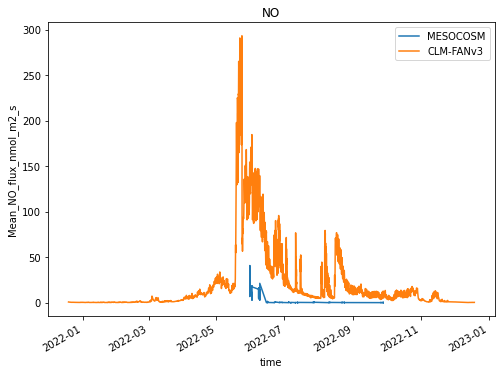

In [6]:
NO = (dsCLM.NOx_NITRIFY_TOTAL + dsCLM.NOx_DENITRIFY_TOTAL + dsCLM.F_NOx_NIT + dsCLM.F_NOx_DENIT)*1e9*30/14
NO.attrs['units'] = "nmol/m2/s"
#dsTIME = pd.DataFrame({'date':dsCLM.time.dt.strftime("%Y-%m-%d %H:%M:%S")})
NO['time'] = [cftime.date2num(x, "days since 1970-01-01") for x in NO.time]

fig, ax = plt.subplots(figsize=(8, 6))
dsNO['Mean_NO_flux_nmol_m2_s'].plot(ax=ax, label='MESOCOSM')
NO.plot(ax=ax, label='CLM-FANv3')

ax.set_title("NO")
ax.set_ylabel("Mean_NO_flux_nmol_m2_s")
ax.legend()
fig.savefig("NO_emission.jpg", dpi=200)
plt.show()

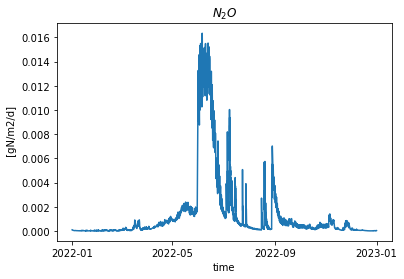

In [7]:
N2O = (dsCLM.N2O_NITRIFY_TOTAL + dsCLM.N2O_DENITRIFY_TOTAL+ dsCLM.F_N2O_NIT + dsCLM.F_N2O_DENIT)*24*3600
N2O.attrs['units'] = "gN/m2/d"
N2O.plot()
plt.title("$N_2O$")
plt.savefig("N2O_emission.jpg", dpi=250)
plt.show()

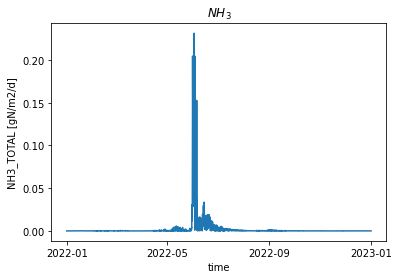

In [8]:
NH3 = dsCLM.NH3_TOTAL*24*3600
NH3.attrs['units'] = "gN/m2/d"
NH3.plot()
plt.title("$NH_3$")
plt.savefig("NH3_emission.jpg", dpi=200)
plt.show()

In [9]:
def preprocess(ds, fields=NInput):
    return(ds[fields])

dsCLM = xr.open_mfdataset(CLM, decode_times=True, preprocess=preprocess)

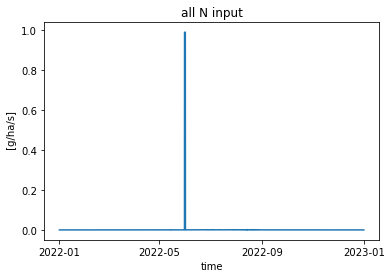

In [10]:
fert = (dsCLM.MANURE_N_GRZ + dsCLM.MANURE_N_BARNS + dsCLM.FERT_N_APP +  dsCLM.NFIX + dsCLM.NDEP_TO_SMINN )*1e4
fert.attrs['units'] = "g/ha/s"
fert.plot()
plt.title("all N input")
plt.savefig("N_input.png", dpi=200)
plt.show()

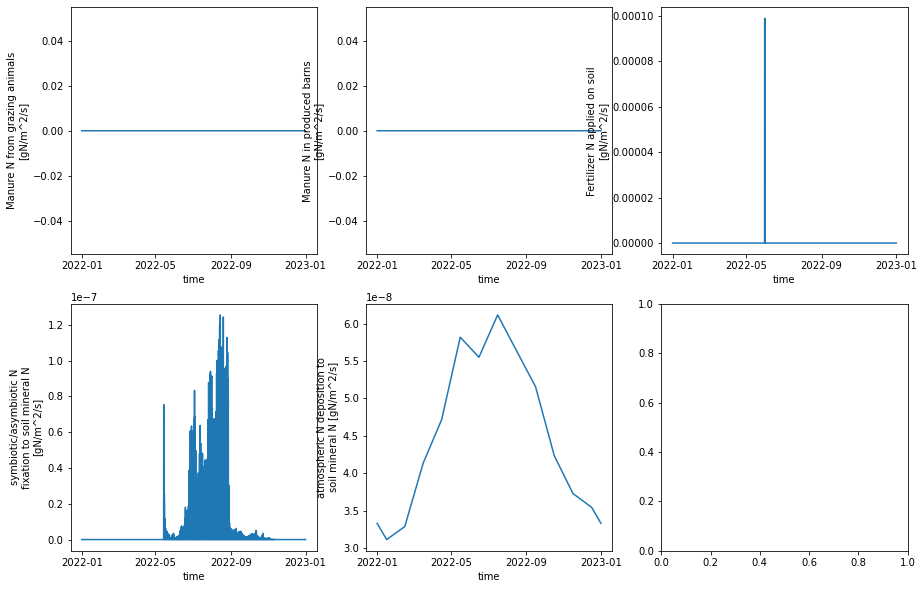

In [11]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
dsCLM.MANURE_N_GRZ.plot(ax=ax[0, 0]) 
dsCLM.MANURE_N_BARNS.plot(ax=ax[0, 1])  
dsCLM.FERT_N_APP.plot(ax=ax[0, 2])   
dsCLM.NFIX.plot(ax=ax[1, 0])  
dsCLM.NDEP_TO_SMINN.plot(ax=ax[1, 1]) 
plt.savefig("N_input2.png", dpi=200)